In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import *

In [11]:
# Read in data
beer = pd.read_csv("monthly-beer-production-in-austr.csv")

In [12]:
# Format type to date
beer['Month'] = pd.to_datetime(beer['Month'], format = "%Y-%m-%d")

In [10]:
print(beer.columns)

Index(['Monthly beer production'], dtype='object')


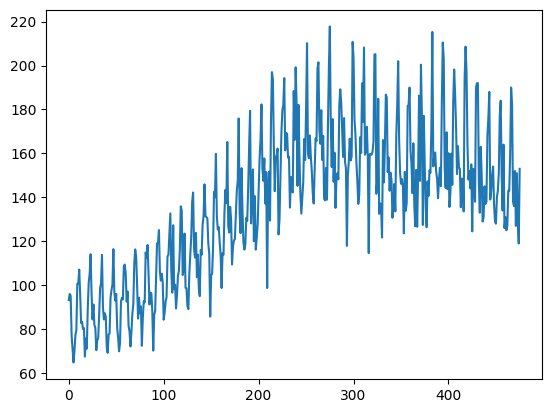

In [13]:
# Plot
plt.plot(beer.index, beer['Monthly beer production'])


Not stationary

In [ ]:
# Take the log diff 
beer['log'] = np.log(beer['Monthly beer production'])
beer['log_diff'] = beer['Monthly beer production'].diff().dropna()
beer.head

<bound method NDFrame.head of          Month  Monthly beer production       log  log_diff
0   1956-01-01                     93.2  4.534748       NaN
1   1956-02-01                     96.0  4.564348       2.8
2   1956-03-01                     95.2  4.555980      -0.8
3   1956-04-01                     77.1  4.345103     -18.1
4   1956-05-01                     70.9  4.261270      -6.2
..         ...                      ...       ...       ...
471 1995-04-01                    127.0  4.844187     -25.0
472 1995-05-01                    151.0  5.017280      24.0
473 1995-06-01                    130.0  4.867534     -21.0
474 1995-07-01                    119.0  4.779123     -11.0
475 1995-08-01                    153.0  5.030438      34.0

[476 rows x 4 columns]>

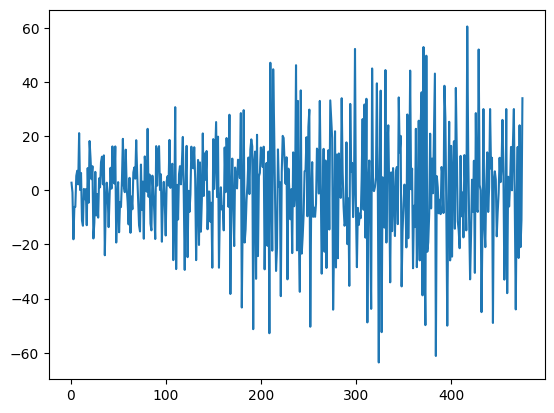

In [23]:
# Plot 
plt.plot(beer.index, beer.log_diff)

In [34]:
# Dickey-Fuller test for stationarity
result=adfuller(beer['log_diff'].dropna())

print('ADF Statistic', result[0])
print('p-value', result[1])
print('Critical Values', result[4])

ADF Statistic -4.9806637430648015
p-value 2.423411785995969e-05
Critical Values {'1%': -3.4447721346720885, '5%': -2.8678991615065095, '10%': -2.570157193174823}


Null-Hypothesis: Non-stationary
Negative ADF statistic that is lower than all critical values, and a very small p-value, we reject the null

Text(0, 0.5, 'PACF')

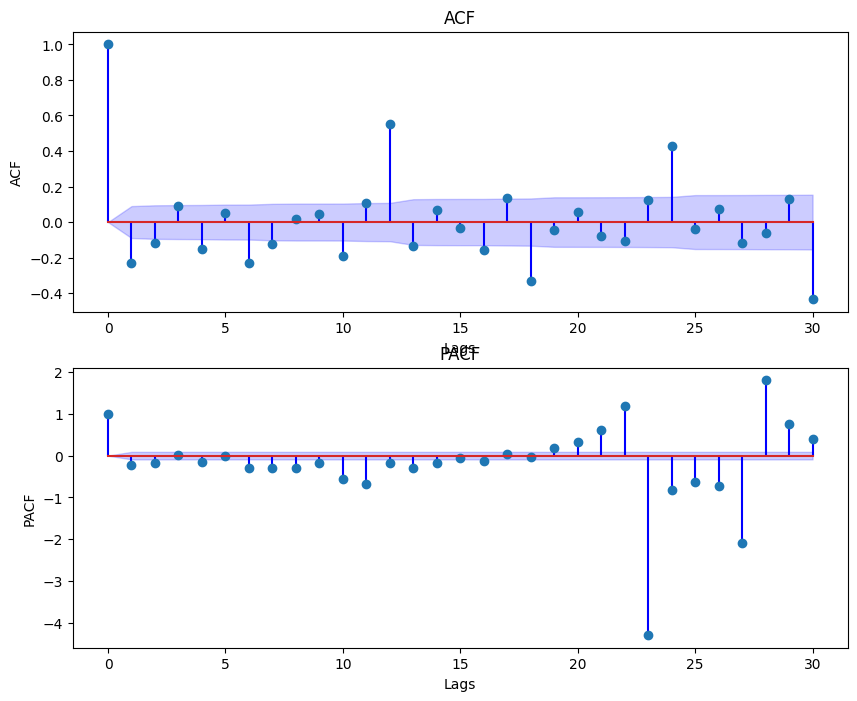

In [35]:
# Plotting ACF and PACF

production_data = beer['log_diff'].dropna()

# Caluculate ACF and PACF and confidence intervals
acf_values, acf_confit = acf(production_data, alpha=0.05, nlags=30)
pacf_values, pacf_confit = pacf(production_data, alpha=0.05, nlags=30)

# Set figure
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# ACF plot
ax[0].stem(range(len(acf_values)), acf_values, linefmt='b-')
ax[0].fill_between(range(len(acf_values)), acf_confit[:,0] - acf_values, acf_confit[:,1]-acf_values, color='blue', alpha=0.2)
ax[0].set_title('ACF')
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('ACF')

# PACF plot
ax[1].stem(range(len(pacf_values)), pacf_values, linefmt='b-')
ax[1].fill_between(range(len(pacf_values)), pacf_confit[:,0]-pacf_values, pacf_confit[:,1]-pacf_values, color='blue', alpha=0.2)
ax[1].set_title('PACF')
ax[1].set_xlabel('Lags')
ax[1].set_ylabel('PACF')

In [47]:
# Train model
log_diff_series = beer['log_diff'].dropna()
model = auto_arima(log_diff_series, seasonal=True, stepwise=True, m=12, trace=False)
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  475
Model:             SARIMAX(5, 0, 4)x(1, 0, [1], 12)   Log Likelihood               -1723.373
Date:                              Wed, 13 Nov 2024   AIC                           3470.746
Time:                                      18:52:36   BIC                           3520.706
Sample:                                           0   HQIC                          3490.393
                                              - 475                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2571      0.053     -4.893      0.000      -0.360      -0.154
ar.L2         -0.12

count    475.000000
mean      -0.091918
std        9.135428
min      -44.712148
25%       -4.644989
50%        0.016147
75%        5.746588
max       30.344117
dtype: float64


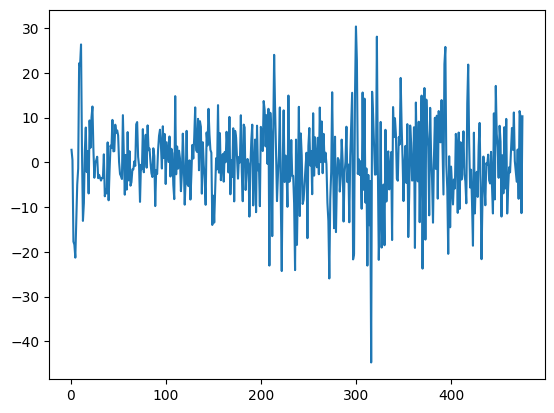

In [48]:
residuals = model.resid()

print(pd.Series(residuals).describe())
plt.plot(residuals)

Text(0, 0.5, 'ACF')

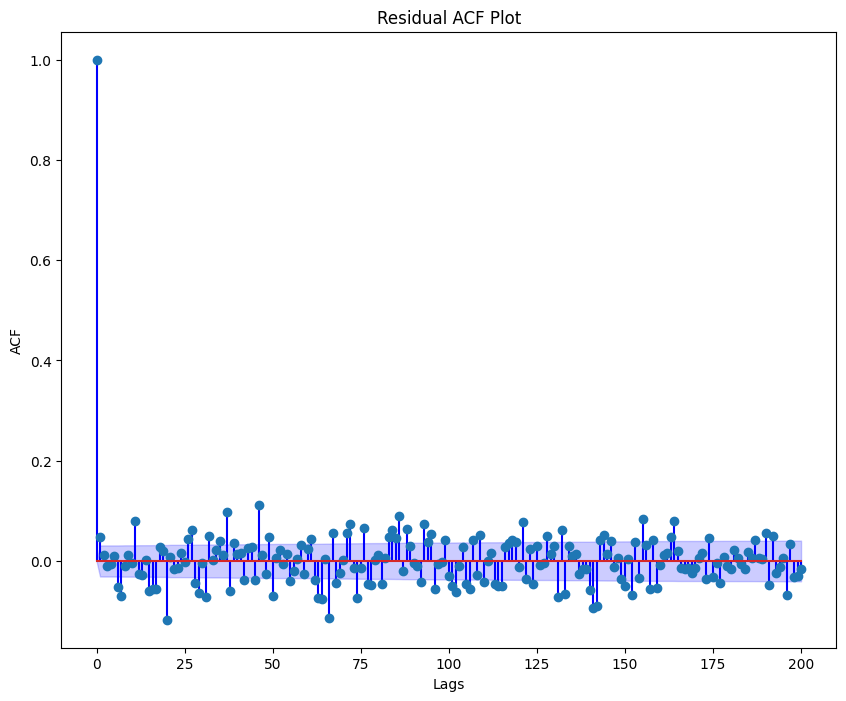

In [49]:
acf_values, acf_confit = acf(residuals, alpha=0.5, nlags=200)
pacf_values, pacf_values = pacf(residuals, alpha=0.5, nlags=200)

# Figure
plt.figure(figsize=(10,8))

plt.stem(range(len(acf_values)), acf_values, linefmt='b-')
plt.fill_between(range(len(acf_values)), acf_confit[:,0]-acf_values, acf_confit[:,1]-acf_values, color='blue', alpha=0.2)
plt.title("Residual ACF Plot")
plt.xlabel("Lags")
plt.ylabel("ACF")
